In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

pd.set_option("display.max_column", 999)

In [2]:
tourney_results = pd.concat([
    pd.read_csv("MNCAATourneyDetailedResults.csv"),
    pd.read_csv("WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv("MNCAATourneySeeds.csv"),
    pd.read_csv("WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv("MRegularSeasonDetailedResults.csv"),
    pd.read_csv("WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

In [3]:
tourney_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [4]:
regular_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [5]:
regular_results_swap = regular_results[[
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

In [6]:
regular_results.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23


In [7]:
regular_results_swap.head(3)

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,WLoc,NumOT,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25


In [8]:
regular_results_swap.loc[regular_results['WLoc'] == 'A', 'WLoc'] = 'H'


regular_results_swap.loc[regular_results['WLoc'] == 'H', 'WLoc'] = 'A'


regular_results.columns.values[6] = 'location'
regular_results_swap.columns.values[6] = 'location'

In [9]:
regular_results.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,location,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23


Swapping here so the model doesnt know

In [10]:
regular_results_swap.head(3)

,Season,DayNum,LTeamID,LScore,WTeamID,WScore,location,NumOT,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,11,1437,61,1266,73,N,0,22,73,3,26,14,23,31,22,9,12,2,5,23,24,58,8,18,17,29,17,26,15,10,5,2,25


In [11]:
regular_results.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(regular_results.columns)]
regular_results_swap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(regular_results.columns)]

In [12]:
regular_data = pd.concat([regular_results, regular_results_swap]).sort_index().reset_index(drop = True)

Replacing with T1 and T2 so their is no indication of who is winning 

In [13]:
regular_data.head(3)

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1328,62,1104,68,N,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22
2,2003,10,1393,63,1272,70,N,0,24,67,6,24,9,20,20,25,7,12,8,6,16,26,62,8,20,10,19,15,28,16,13,4,4,18


In [14]:
tourney_results = pd.concat([
    pd.read_csv("MNCAATourneyDetailedResults.csv"),
    pd.read_csv("WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv("MNCAATourneySeeds.csv"),
    pd.read_csv("WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv("MRegularSeasonDetailedResults.csv"),
    pd.read_csv("WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

In [15]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [16]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [17]:
regular_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

In [18]:
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'PointDiff'],
      dtype='object')

Getting Mean from season for below this 

In [19]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [20]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)
season_statistics.head()

T1_FGM     T1_FGA   T1_FGM3    T1_FGA3      T1_OR  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       19.142857  39.785714  7.821429  20.821429   4.178571   
       1103       27.148148  55.851852  5.444444  16.074074   9.777778   
       1104       24.035714  57.178571  6.357143  19.857143  13.571429   
       1105       24.384615  61.615385  7.576923  20.769231  13.500000   
       1106       23.428571  55.285714  6.107143  17.642857  12.285714   

                     T1_Ast      T1_TO    T1_Stl      T1_PF     T2_FGM  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       13.000000  11.428571  5.964286  18.750000  19.285714   
       1103       15.222222  12.629630  7.259259  19.851852  27.777778   
       1104       12.107143  13.285714  6.607143  18.035714  23.250000   
       1105       14.538462  18.653846  9.307692  20.230769  27.000000   
       1106       11.678571  17.035714  8.357143  18.178571  21.714286   

                     T2_FGA   T2_FGM3    T2_FGA3      T2_OR     T2_Ast  \
                       mean      mean       mean       mean       mean   
Season T1_TeamID                                                         
2003   1102       42.428571  4.750000  12.428571   9.607143   9.142857   
       1103       57.000000  6.666667  18.370370  12.037037  15.481481   
       1104       55.500000  6.357143  19.142857  10.892857  11.678571   
       1105       58.961538  6.269231  17.538462  13.192308  15.807692   
       1106       53.392857  4.785714  15.214286  11.321429  11.785714   

                      T2_TO    T2_Stl    T2_Blk PointDiff  
                       mean      mean      mean      mean  
Season T1_TeamID                                           
2003   1102       12.964286  5.428571  1.571429  0.250000  
       1103       15.333333  6.407407  2.851852  0.629630  
       1104       13.857143  5.535714  3.178571  4.285714  
       1105       18.807692  9.384615  4.192308 -4.884615  
       1106       15.071429  8.785714  3.178571 -0.142857

In [21]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
season_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [22]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


## Breaking down into Team 1 and Team 2

In [23]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [24]:
season_statistics_T1.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [25]:
season_statistics_T2.head()

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2003,1102,19.142857,39.785714,7.821429,20.821429,4.178571,13.000000,11.428571,5.964286,18.750000,19.285714,42.428571,4.750000,12.428571,9.607143,9.142857,12.964286,5.428571,1.571429,0.250000
1,2003,1103,27.148148,55.851852,5.444444,16.074074,9.777778,15.222222,12.629630,7.259259,19.851852,27.777778,57.000000,6.666667,18.370370,12.037037,15.481481,15.333333,6.407407,2.851852,0.629630
2,2003,1104,24.035714,57.178571,6.357143,19.857143,13.571429,12.107143,13.285714,6.607143,18.035714,23.250000,55.500000,6.357143,19.142857,10.892857,11.678571,13.857143,5.535714,3.178571,4.285714
3,2003,1105,24.384615,61.615385,7.576923,20.769231,13.500000,14.538462,18.653846,9.307692,20.230769,27.000000,58.961538,6.269231,17.538462,13.192308,15.807692,18.807692,9.384615,4.192308,-4.884615
4,2003,1106,23.428571,55.285714,6.107143,17.642857,12.285714,11.678571,17.035714,8.357143,18.178571,21.714286,53.392857,4.785714,15.214286,11.321429,11.785714,15.071429,8.785714,3.178571,-0.142857


In [26]:
season_statistics_T2 = season_statistics_T2[season_statistics_T2['Season'] >= 2015]
season_statistics_T1 = season_statistics_T1[season_statistics_T1['Season'] >= 2015]

In [27]:
mteams_df = pd.read_csv('MTeams.csv')
mteams_df

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2024
1,1102,Air Force,1985,2024
2,1103,Akron,1985,2024
3,1104,Alabama,1985,2024
4,1105,Alabama A&M,2000,2024
...,...,...,...,...
373,1474,Queens NC,2023,2024
374,1475,Southern Indiana,2023,2024
375,1476,Stonehill,2023,2024
376,1477,TX A&M Commerce,2023,2024


In [28]:
merged_df_T2 = pd.merge(season_statistics_T2, mteams_df, left_on='T2_TeamID', right_on='TeamID')

In [29]:
merged_df_T1 = pd.merge(season_statistics_T1, mteams_df, left_on='T1_TeamID', right_on='TeamID')
merged_df_T1

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,TeamID,TeamName,FirstD1Season,LastD1Season
0,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,Abilene Chr,2014,2024
1,2016,1101,23.814815,53.925926,6.851852,18.851852,8.185185,12.888889,13.407407,6.740741,22.370370,26.481481,53.666667,5.592593,15.148148,8.592593,12.851852,13.444444,5.111111,3.296296,-6.407407,1101,Abilene Chr,2014,2024
2,2017,1101,24.440000,53.320000,7.080000,19.080000,7.560000,13.600000,14.480000,7.000000,22.160000,24.840000,53.680000,7.080000,19.600000,10.640000,13.600000,14.800000,6.040000,3.160000,-4.760000,1101,Abilene Chr,2014,2024
3,2018,1101,25.518519,56.481481,6.481481,19.962963,9.037037,13.888889,14.407407,7.148148,21.037037,24.777778,54.296296,6.629630,19.740741,9.925926,12.037037,15.481481,6.518519,2.925926,-2.148148,1101,Abilene Chr,2014,2024
4,2019,1101,25.344828,55.241379,7.241379,18.896552,9.068966,14.620690,11.655172,8.000000,19.137931,22.482759,51.137931,5.724138,17.103448,8.827586,11.103448,15.724138,5.551724,2.965517,6.827586,1101,Abilene Chr,2014,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,2023,1476,22.900000,52.433333,7.533333,21.633333,4.966667,11.900000,12.800000,6.966667,15.133333,25.366667,58.833333,8.300000,24.000000,9.566667,13.900000,12.900000,6.966667,2.933333,-4.266667,1476,Stonehill,2023,2024
3536,2024,1476,22.933333,57.933333,8.200000,27.200000,6.866667,11.866667,12.966667,6.266667,15.466667,26.966667,60.700000,10.066667,28.033333,9.766667,16.400000,11.166667,7.900000,4.266667,-14.000000,1476,Stonehill,2023,2024
3537,2023,1477,25.593750,56.687500,8.250000,25.843750,7.500000,13.843750,12.437500,5.562500,18.750000,26.093750,55.843750,6.781250,19.500000,8.125000,13.031250,11.625000,6.406250,2.187500,-3.562500,1477,TX A&M Commerce,2023,2024
3538,2024,1477,23.300000,59.400000,8.033333,27.333333,7.500000,12.266667,11.000000,7.366667,17.666667,27.133333,57.600000,6.133333,17.500000,9.466667,13.833333,12.333333,5.800000,3.633333,-9.333333,1477,TX A&M Commerce,2023,2024


Scrape Try

In [30]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import requests
import time
import requests

In [31]:

base_urls=[
          'https://web.archive.org/web/20110311233233/http://www.kenpom.com/',
          'https://web.archive.org/web/20120311165019/http://kenpom.com/',
          'https://web.archive.org/web/20130318221134/http://kenpom.com/',
          'https://web.archive.org/web/20140318100454/http://kenpom.com/',
          'https://web.archive.org/web/20150316212936/http://kenpom.com/',
          'https://web.archive.org/web/20160314134726/http://kenpom.com/',
          'https://web.archive.org/web/20170312131016/http://kenpom.com/',
          'https://web.archive.org/web/20180311122559/https://kenpom.com/',
          'https://web.archive.org/web/20190317211809/https://kenpom.com/',
    'https://web.archive.org/web/20200319000000/https://kenpom.com/index.php?y=2020', # Adjust the timestamp accordingly
    'https://web.archive.org/web/20210319000000/https://kenpom.com/index.php?y=2021', # Adjust the timestamp accordingly
    'https://web.archive.org/web/20220319000000/https://kenpom.com/index.php?y=2022', # Adjust the timestamp accordingly
    'https://web.archive.org/web/20230319000000/https://kenpom.com/index.php?y=2023', # Adjust the timestamp accordingly
    'https://web.archive.org/web/20240319000000/https://kenpom.com/index.php', #
         ]


def scrap_archive(url, year):
    """
    Imports raw data from a kenpom archive into a dataframe
    """
    retries = 3
    delay = 1  # Delay in seconds between retries
    for _ in range(retries):
        try:
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
            page = requests.get(url, headers=headers)
            soup = BeautifulSoup(page.text, 'html.parser')
            table_full = soup.find_all('table', {'id': 'ratings-table'})

            thead = table_full[0].find_all('thead')
            table = table_full[0]

            for weird in thead:
                table = str(table).replace(str(weird), '')

            df = pd.read_html(table)[0]
            df['Year'] = year
            return df
        except requests.ConnectionError as e:
            print(f"Connection error occurred: {e}")
            print(f"Retrying in {delay} seconds...")
            time.sleep(delay)
            continue
    else:
        # If all retries fail, raise the last exception
        Exception("Failed to connect after multiple retries")


In [32]:
def scraping(df, year):
    for url in base_urls:
        print(f'Scraping: {url}')
        archive = scrap_archive(url, year)
        df = pd.concat((df, archive), axis=0)
        year += 1
    
    df.columns = ['Rank', 'Team', 'Conference', 'W-L', 'Pyth', 
             'AdjustO', 'AdjustO Rank', 'AdjustD', 'AdjustD Rank',
             'AdjustT', 'AdjustT Rank', 'Luck', 'Luck Rank', 
             'SOS Pyth', 'SOS Pyth Rank', 'SOS OppO', 'SOS OppO Rank',
             'SOS OppD', 'SOS OppD Rank', 'NCSOS Pyth', 'NCSOS Pyth Rank', 'Year']
    
    df = df[['Year', 'Team', 'AdjustO', 'AdjustD', 'Luck', 'Rank', 'Pyth']]
    df.columns = ['Season', 'TeamName', 'adj_o', 'adj_d', 'luck', 'rank', 'pyth']
    df['TeamName'] = df['TeamName'].apply(lambda x: re.sub('\d', '', x).strip()).replace('.','')
    return df

In [33]:
df=None
year=2011
df=scraping(df,year)
df.head()

Scraping: https://web.archive.org/web/20110311233233/http://www.kenpom.com/
Scraping: https://web.archive.org/web/20120311165019/http://kenpom.com/
Scraping: https://web.archive.org/web/20130318221134/http://kenpom.com/
Scraping: https://web.archive.org/web/20140318100454/http://kenpom.com/
Scraping: https://web.archive.org/web/20150316212936/http://kenpom.com/
Scraping: https://web.archive.org/web/20160314134726/http://kenpom.com/
Scraping: https://web.archive.org/web/20170312131016/http://kenpom.com/
Connection error occurred: HTTPSConnectionPool(host='web.archive.org', port=443): Max retries exceeded with url: /web/20170312131016/http://kenpom.com/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x17ece76d0>: Failed to establish a new connection: [Errno 61] Connection refused'))
Retrying in 1 seconds...
Connection error occurred: HTTPSConnectionPool(host='web.archive.org', port=443): Max retries exceeded with url: /web/20170312131016/http://kenpom.com/ (

,Season,TeamName,adj_o,adj_d,luck,rank,pyth
0,2011,Ohio St.,125.4,88.4,0.043,1,0.9824
1,2011,Duke,118.8,87.2,0.006,2,0.9720
2,2011,Kansas,119.8,88.3,0.071,3,0.9711
3,2011,Texas,114.0,85.3,-0.055,4,0.9657
4,2011,Purdue,116.1,87.2,-0.004,5,0.9641


In [34]:
df_KP = df.copy()
df_KP

,Season,TeamName,adj_o,adj_d,luck,rank,pyth
0,2011,Ohio St.,125.4,88.4,0.043,1,0.9824
1,2011,Duke,118.8,87.2,0.006,2,0.9720
2,2011,Kansas,119.8,88.3,0.071,3,0.9711
3,2011,Texas,114.0,85.3,-0.055,4,0.9657
4,2011,Purdue,116.1,87.2,-0.004,5,0.9641
...,...,...,...,...,...,...,...
358,2023,Florida A&M,89.4,110.1,0.005,359,-20.7400
359,2023,IUPUI,95.6,117.7,-0.076,360,-22.0300
360,2023,Green Bay,90.3,116.7,0.029,361,-26.4000
361,2023,Hartford,89.5,118.6,-0.039,362,-29.0700


In [35]:
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.replace('-',' '))
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.lower())
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.strip())
df_KP.TeamName=df_KP.TeamName.replace('mississippi valley st.','mississippi valley state')
#df.TeamName=df.TeamName.replace('texas a&m corpus chris','texas a&m corpus christi')
df_KP.TeamName=df_KP.TeamName.replace('dixie st.','dixie st')
df_KP.TeamName=df_KP.TeamName.replace('st. francis pa','st francis pa')
df_KP.TeamName=df_KP.TeamName.replace('ut rio grande valley','texas rio grande valley')
df_KP.TeamName=df_KP.TeamName.replace('southeast missouri st.','southeast missouri state')
df_KP.TeamName=df_KP.TeamName.replace('tarleton st.','tarleton st')
df_KP.TeamName=df_KP.TeamName.replace('liu','liu brooklyn')
df_KP.TeamName=df_KP.TeamName.replace('cal st. bakersfield','cal state bakersfield')

df_KP.TeamName=df_KP.TeamName.replace('virginia military inst','virginia military	')
df_KP.TeamName=df_KP.TeamName.replace('louisiana saint','louisiana state')
df_KP.TeamName=df_KP.TeamName.replace('nj inst of technology','njit')

df_KP.TeamName=df_KP.TeamName.replace('texas a&m corpus chris','texas a&m corpus')
df_KP.TeamName=df_KP.TeamName.replace('md baltimore county','maryland baltimore county')
#-------------------------------------------------------
# merge with spelling file to get the TeamID
spelling=pd.read_csv('MTeamSpellings.csv',encoding='cp1252')
spelling.columns=['TeamName','TeamID']
spelling.TeamName=spelling.TeamName.apply(lambda x: x.replace('-',' '))
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.strip())


df_KP=df_KP.merge(spelling[['TeamName','TeamID']],on='TeamName',how='left')

df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.replace('st.','saint'))
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.replace(';',''))
df_KP.TeamName=df_KP.TeamName.apply(lambda x: x.replace('\t',''))
df_KP.TeamName=df_KP.TeamName.replace('texas a&m corpus chris','texas a&m corpus')
df_KP.TeamName=df_KP.TeamName.replace('louisiana saint','louisiana state')

df_KP=df_KP.merge(spelling[['TeamName','TeamID']],on='TeamName',how='left')

df_KP.TeamID_x.fillna(df_KP.TeamID_y, inplace=True)

df_KP=df_KP[['Season','TeamID_x','adj_o','adj_d','luck','rank','pyth']]
df_KP.columns=['Season','TeamID','adj_o','adj_d','luck','rank','pyth']
df_KP['TeamID'] = df_KP['TeamID'].astype('Int64')

In [36]:
df_KP.columns=['Season','TeamID','adj_o','adj_d','luck','rank','adj_em']
df_KP

,Season,TeamID,adj_o,adj_d,luck,rank,adj_em
0,2011,1326,125.4,88.4,0.043,1,0.9824
1,2011,1181,118.8,87.2,0.006,2,0.9720
2,2011,1242,119.8,88.3,0.071,3,0.9711
3,2011,1400,114.0,85.3,-0.055,4,0.9657
4,2011,1345,116.1,87.2,-0.004,5,0.9641
...,...,...,...,...,...,...,...
5426,2023,1216,89.5,118.6,-0.039,362,-29.0700
5427,2023,1254,86.8,116.4,-0.024,363,-29.5800
5428,2023,1254,86.8,116.4,-0.024,363,-29.5800
5429,2023,1254,86.8,116.4,-0.024,363,-29.5800


In [37]:
# DROP THESE ROWS
print(df_KP[df_KP['TeamID'].isnull()])

      Season  TeamID  adj_o  adj_d   luck  rank  adj_em
4713    2022    <NA>   93.5  111.1  0.000   339  -17.59
4994    2023    <NA>  107.7  106.3 -0.100   146    1.38
5098    2023    <NA>  107.4  109.6 -0.001   202   -2.15
5099    2023    <NA>  107.1  109.4  0.003   203   -2.34
5264    2023    <NA>  102.6  112.0 -0.007   284   -9.42
5313    2023    <NA>  101.1  112.4  0.026   306  -11.25
5368    2023    <NA>   94.9  109.5  0.072   331  -14.57
5398    2023    <NA>   95.5  112.2  0.004   343  -16.71
5411    2023    <NA>  101.8  120.7 -0.020   353  -18.92


In [38]:
df_KP = df_KP.dropna(subset=['TeamID'])
print(df_KP[df_KP['TeamID'].isnull()])

Empty DataFrame
Columns: [Season, TeamID, adj_o, adj_d, luck, rank, adj_em]
Index: []


In [39]:
season_statistics_T1 = pd.merge(season_statistics_T1, df_KP, left_on=['Season', 'T1_TeamID'], right_on=['Season', 'TeamID'], how='left')
season_statistics_T2 = pd.merge(season_statistics_T2, df_KP, left_on=['Season', 'T2_TeamID'], right_on=['Season', 'TeamID'], how='left')
season_statistics_T2.columns

Index(['Season', 'T2_TeamID', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean',
       'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean',
       'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean',
       'T2_opponent_Blkmean', 'T2_PointDiffmean', 'TeamID', 'adj_o', 'adj_d',
       'luck', 'rank', 'adj_em'],
      dtype='object')

In [40]:
column_renaming_map1 = {
    "adj_o": "T1_adj_o",
    "adj_d": "T1_adj_d",
    "luck": "T1_luck",
    "rank": "T1_rank",
    "adj_em": "T1_adj_em"
}

column_renaming_map2 = {
    "adj_o": "T2_adj_o",
    "adj_d": "T2_adj_d",
    "luck": "T2_luck",
    "rank": "T2_rank",
    "adj_em": "T2_adj_em"
}

In [41]:
# Renaming columns in season_statistics_T1 using the map
season_statistics_T1.rename(columns=column_renaming_map1, inplace=True)
season_statistics_T1

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,TeamID,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em
0,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
1,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
2,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
3,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
4,2015,1102,23.620690,50.758621,7.172414,20.241379,8.793103,14.896552,11.724138,6.310345,17.827586,22.689655,50.482759,8.137931,22.241379,10.034483,14.448276,12.379310,5.793103,3.620690,-1.137931,1102,106.1,109.2,-0.065,203.0,0.4175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,2024,1474,26.967742,62.516129,8.419355,25.516129,8.645161,12.258065,11.193548,6.645161,17.451613,30.516129,63.774194,8.000000,23.419355,9.096774,12.645161,10.903226,6.516129,4.774194,-5.258065,<NA>,NaN,NaN,NaN,NaN,NaN
7959,2024,1475,22.379310,56.206897,6.448276,20.379310,8.482759,10.862069,12.827586,6.137931,21.620690,24.034483,55.551724,6.931034,20.827586,8.448276,12.379310,11.068966,6.862069,3.448276,-8.034483,<NA>,NaN,NaN,NaN,NaN,NaN
7960,2024,1476,22.933333,57.933333,8.200000,27.200000,6.866667,11.866667,12.966667,6.266667,15.466667,26.966667,60.700000,10.066667,28.033333,9.766667,16.400000,11.166667,7.900000,4.266667,-14.000000,<NA>,NaN,NaN,NaN,NaN,NaN
7961,2024,1477,23.300000,59.400000,8.033333,27.333333,7.500000,12.266667,11.000000,7.366667,17.666667,27.133333,57.600000,6.133333,17.500000,9.466667,13.833333,12.333333,5.800000,3.633333,-9.333333,<NA>,NaN,NaN,NaN,NaN,NaN


In [42]:
season_statistics_T2.rename(columns=column_renaming_map2, inplace=True)
season_statistics_T2

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,TeamID,T2_adj_o,T2_adj_d,T2_luck,T2_rank,T2_adj_em
0,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
1,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
2,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
3,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
4,2015,1102,23.620690,50.758621,7.172414,20.241379,8.793103,14.896552,11.724138,6.310345,17.827586,22.689655,50.482759,8.137931,22.241379,10.034483,14.448276,12.379310,5.793103,3.620690,-1.137931,1102,106.1,109.2,-0.065,203.0,0.4175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,2024,1474,26.967742,62.516129,8.419355,25.516129,8.645161,12.258065,11.193548,6.645161,17.451613,30.516129,63.774194,8.000000,23.419355,9.096774,12.645161,10.903226,6.516129,4.774194,-5.258065,<NA>,NaN,NaN,NaN,NaN,NaN
7959,2024,1475,22.379310,56.206897,6.448276,20.379310,8.482759,10.862069,12.827586,6.137931,21.620690,24.034483,55.551724,6.931034,20.827586,8.448276,12.379310,11.068966,6.862069,3.448276,-8.034483,<NA>,NaN,NaN,NaN,NaN,NaN
7960,2024,1476,22.933333,57.933333,8.200000,27.200000,6.866667,11.866667,12.966667,6.266667,15.466667,26.966667,60.700000,10.066667,28.033333,9.766667,16.400000,11.166667,7.900000,4.266667,-14.000000,<NA>,NaN,NaN,NaN,NaN,NaN
7961,2024,1477,23.300000,59.400000,8.033333,27.333333,7.500000,12.266667,11.000000,7.366667,17.666667,27.133333,57.600000,6.133333,17.500000,9.466667,13.833333,12.333333,5.800000,3.633333,-9.333333,<NA>,NaN,NaN,NaN,NaN,NaN


In [43]:
season_statistics_T1

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,TeamID,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em
0,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
1,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
2,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
3,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
4,2015,1102,23.620690,50.758621,7.172414,20.241379,8.793103,14.896552,11.724138,6.310345,17.827586,22.689655,50.482759,8.137931,22.241379,10.034483,14.448276,12.379310,5.793103,3.620690,-1.137931,1102,106.1,109.2,-0.065,203.0,0.4175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,2024,1474,26.967742,62.516129,8.419355,25.516129,8.645161,12.258065,11.193548,6.645161,17.451613,30.516129,63.774194,8.000000,23.419355,9.096774,12.645161,10.903226,6.516129,4.774194,-5.258065,<NA>,NaN,NaN,NaN,NaN,NaN
7959,2024,1475,22.379310,56.206897,6.448276,20.379310,8.482759,10.862069,12.827586,6.137931,21.620690,24.034483,55.551724,6.931034,20.827586,8.448276,12.379310,11.068966,6.862069,3.448276,-8.034483,<NA>,NaN,NaN,NaN,NaN,NaN
7960,2024,1476,22.933333,57.933333,8.200000,27.200000,6.866667,11.866667,12.966667,6.266667,15.466667,26.966667,60.700000,10.066667,28.033333,9.766667,16.400000,11.166667,7.900000,4.266667,-14.000000,<NA>,NaN,NaN,NaN,NaN,NaN
7961,2024,1477,23.300000,59.400000,8.033333,27.333333,7.500000,12.266667,11.000000,7.366667,17.666667,27.133333,57.600000,6.133333,17.500000,9.466667,13.833333,12.333333,5.800000,3.633333,-9.333333,<NA>,NaN,NaN,NaN,NaN,NaN


In [44]:
season_statistics_T2

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,TeamID,T2_adj_o,T2_adj_d,T2_luck,T2_rank,T2_adj_em
0,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
1,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
2,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
3,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
4,2015,1102,23.620690,50.758621,7.172414,20.241379,8.793103,14.896552,11.724138,6.310345,17.827586,22.689655,50.482759,8.137931,22.241379,10.034483,14.448276,12.379310,5.793103,3.620690,-1.137931,1102,106.1,109.2,-0.065,203.0,0.4175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,2024,1474,26.967742,62.516129,8.419355,25.516129,8.645161,12.258065,11.193548,6.645161,17.451613,30.516129,63.774194,8.000000,23.419355,9.096774,12.645161,10.903226,6.516129,4.774194,-5.258065,<NA>,NaN,NaN,NaN,NaN,NaN
7959,2024,1475,22.379310,56.206897,6.448276,20.379310,8.482759,10.862069,12.827586,6.137931,21.620690,24.034483,55.551724,6.931034,20.827586,8.448276,12.379310,11.068966,6.862069,3.448276,-8.034483,<NA>,NaN,NaN,NaN,NaN,NaN
7960,2024,1476,22.933333,57.933333,8.200000,27.200000,6.866667,11.866667,12.966667,6.266667,15.466667,26.966667,60.700000,10.066667,28.033333,9.766667,16.400000,11.166667,7.900000,4.266667,-14.000000,<NA>,NaN,NaN,NaN,NaN,NaN
7961,2024,1477,23.300000,59.400000,8.033333,27.333333,7.500000,12.266667,11.000000,7.366667,17.666667,27.133333,57.600000,6.133333,17.500000,9.466667,13.833333,12.333333,5.800000,3.633333,-9.333333,<NA>,NaN,NaN,NaN,NaN,NaN


# About to Merge with Tourney Data

In [45]:
#tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
#tourney_data.head()

# Merging with Ken Pom

In [46]:
#tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
#tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
#tourney_data = tourney_data.drop(tourney_data.filter(regex='_x|_y').columns, axis=1)
#tourney_data = tourney_data[tourney_data['Season'] >= 2015]
#tourney_data.columns

# Stars Add in

In [47]:
# import requests
# from bs4 import BeautifulSoup
# import csv
# import re

# def scrape_season(year):
#     url = f"https://247sports.com/Season/{year}-Basketball/RecruitRankings/?InstitutionGroup=HighSchool"
#     print(f"Scraping URL: {url}")

#     headers = {
#         'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

#     try:
#         response = requests.get(url, headers=headers)
#         response.raise_for_status()
#     except requests.exceptions.HTTPError as err:
#         print(f"HTTP Error: {err}")
#         return
#     except Exception as err:
#         print(f"Error occurred: {err}")
#         return

#     if not response.text:
#         print(f"No data received for {year}, skipping...")
#         return

#     soup = BeautifulSoup(response.text, 'html.parser')
#     recruits = soup.find_all('li', class_='rankings-page__list-item')

#     if not recruits:
#         print(f"No recruits found for {year}, check if page structure is different.")
#         return

#     with open(f'recruits_{year}.csv', 'w', newline='', encoding='utf-8') as file:
#         writer = csv.writer(file)
#         writer.writerow(['Rank', 'Player', 'High School', 'Position', 'Height / Weight', 'Rating', 'Team'])

#         for recruit in recruits:
#             rank = recruit.find('div', class_='primary').get_text(strip=True)
#             name = recruit.find('a', class_='rankings-page__name-link').get_text(strip=True)
#             high_school = recruit.find('div', class_='recruit').get_text(strip=True)
#             position = recruit.find('div', class_='position').get_text(strip=True)
#             height_weight = recruit.find('div', class_='metrics').get_text(strip=True)
#             rating_info = recruit.find('div', class_='rating').get_text(strip=True)
#             match = re.search(r'\b(100|[1-9]?[0-9])', rating_info)
#             rating = match.group(0) if match else 'N/A'
            
#             # Extract team name from alt attribute of img tag within a tag within div with class "status"
#             status_div = recruit.find('div', class_='status')
#             team_alt = 'N/A'
#             if status_div:
#                 img_link = status_div.find('a', class_='img-link')
#                 if img_link:
#                     img_tag = img_link.find('img')
#                     if img_tag:
#                         team_alt = img_tag.get('alt')

#             writer.writerow([rank, name, high_school, position, height_weight, rating, team_alt])

# # Loop through the years
# for year in range(2011, 2025):
#     scrape_season(year)

In [48]:
playerRating_df = pd.DataFrame()

# Loop through each year, read the CSV, add a 'Year' column, and append to the main DataFrame
for year in range(2011, 2025):
    file_name = f'recruits_{year}.csv'
    if os.path.exists(file_name):  # Check if the file exists
        df = pd.read_csv(file_name)
        df['Year'] = year  # Add a column for the year
        playerRating_df = pd.concat([playerRating_df, df], ignore_index=True)

# Save the combined data to a new CSV file
playerRating_df.to_csv('combined_recruits.csv', index=False)

# If you want to see the DataFrame
playerRating_df

,Rank,Player,High School,Position,Height / Weight,Rating,Team,Year
0,1,Anthony Davis,"Anthony DavisPerspectives Charter (Chicago, IL)",PF,6-10 / 220,100,Kentucky,2011
1,2,Michael Kidd-Gilchrist,"Michael Kidd-GilchristSt. Patrick (Elizabeth, NJ)",SF,6-6 / 190,100,Kentucky,2011
2,3,Austin Rivers,"Austin RiversWinter Park (Winter Park, FL)",PG,6-3 / 175,100,Duke,2011
3,4,Bradley Beal,"Bradley BealChaminade (Saint Louis, MO)",SG,6-4 / 195,100,Florida,2011
4,5,Quincy Miller,Quincy MillerWestchester Country Day School (H...,PF,6-8 / 193,100,Baylor,2011
...,...,...,...,...,...,...,...,...
2925,146,Bryce Dortch,Bryce DortchBrimmer And May School (Chestnut H...,PF,6-8 / 190,88,Rutgers,2024
2926,147,Angelo Ciaravino,"Angelo CiaravinoMount Carmel (Chicago, IL)",SF,6-5 / 175,88,Northwestern,2024
2927,148,Malcolm Thomas,"Malcolm ThomasDeMatha Catholic (Hyattsville, MD)",PF,6-8 / 195,88,Villanova,2024
2928,149,Chris Tadjo,Chris TadjoNBA Academy Latin America (Montreal...,PF,6-8 / 220,88,Iowa,2024


In [49]:
def rating_to_stars(rating):
    if 100 >= rating >= 98:
        return 5
    elif 97 >= rating >= 94:
        return 4
    elif 93 >= rating >= 0:
        return 3
    else:
        return None  # or some default value for ratings outside the specified ranges

# Apply the function to the 'Rating' column to create the 'Star' column
playerRating_df['Stars'] = playerRating_df['Rating'].apply(rating_to_stars)

# Now you can check the first few rows of your DataFrame
playerRating_df.head()

,Rank,Player,High School,Position,Height / Weight,Rating,Team,Year,Stars
0,1,Anthony Davis,"Anthony DavisPerspectives Charter (Chicago, IL)",PF,6-10 / 220,100,Kentucky,2011,5
1,2,Michael Kidd-Gilchrist,"Michael Kidd-GilchristSt. Patrick (Elizabeth, NJ)",SF,6-6 / 190,100,Kentucky,2011,5
2,3,Austin Rivers,"Austin RiversWinter Park (Winter Park, FL)",PG,6-3 / 175,100,Duke,2011,5
3,4,Bradley Beal,"Bradley BealChaminade (Saint Louis, MO)",SG,6-4 / 195,100,Florida,2011,5
4,5,Quincy Miller,Quincy MillerWestchester Country Day School (H...,PF,6-8 / 193,100,Baylor,2011,5


In [50]:
top_players = playerRating_df.groupby('Year')['Rating'].min()
print(top_players)

Year
2011    70
2012    10
2013    83
2014    87
2015    87
2016    10
2017    87
2018    88
2019    88
2020    90
2021    89
2022    89
2023    88
2024    88
Name: Rating, dtype: int64


In [51]:
def adjust_rating(row):
    if row['Rating'] == 10:
        return 101
    elif row['Player'] == 'Josh Jackson':
        return 102
    else:
        return row['Rating']

# Apply the function to each row
playerRating_df['Rating'] = playerRating_df.apply(adjust_rating, axis=1)

# Now you can check the first few rows of your DataFrame
playerRating_df.head()

,Rank,Player,High School,Position,Height / Weight,Rating,Team,Year,Stars
0,1,Anthony Davis,"Anthony DavisPerspectives Charter (Chicago, IL)",PF,6-10 / 220,100,Kentucky,2011,5
1,2,Michael Kidd-Gilchrist,"Michael Kidd-GilchristSt. Patrick (Elizabeth, NJ)",SF,6-6 / 190,100,Kentucky,2011,5
2,3,Austin Rivers,"Austin RiversWinter Park (Winter Park, FL)",PG,6-3 / 175,100,Duke,2011,5
3,4,Bradley Beal,"Bradley BealChaminade (Saint Louis, MO)",SG,6-4 / 195,100,Florida,2011,5
4,5,Quincy Miller,Quincy MillerWestchester Country Day School (H...,PF,6-8 / 193,100,Baylor,2011,5


In [52]:
columns = ['Rank', 'Player', 'Team', 'Year', 'Stars']

playerRating_df = playerRating_df[columns]
playerRating_df

,Rank,Player,Team,Year,Stars
0,1,Anthony Davis,Kentucky,2011,5
1,2,Michael Kidd-Gilchrist,Kentucky,2011,5
2,3,Austin Rivers,Duke,2011,5
3,4,Bradley Beal,Florida,2011,5
4,5,Quincy Miller,Baylor,2011,5
...,...,...,...,...,...
2925,146,Bryce Dortch,Rutgers,2024,3
2926,147,Angelo Ciaravino,Northwestern,2024,3
2927,148,Malcolm Thomas,Villanova,2024,3
2928,149,Chris Tadjo,Iowa,2024,3


In [53]:
# Group the DataFrame by 'Team' and 'Year', and count occurrences of 3, 4, and 5 stars
team_year_counts = playerRating_df.groupby(['Team', 'Year'])['Stars'].value_counts().unstack(fill_value=0)

total_stars = (team_year_counts[[3, 4, 5]] * [3, 4, 5]).sum(axis=1)
byTeamStars = team_year_counts[[3, 4, 5]]
byTeamStars['Total Stars'] = total_stars
byTeamStars = byTeamStars.reset_index()
byTeamStars.columns.name = None
byTeamStars.columns = ['Team', 'Year', '3 Stars', '4 Stars', '5 Stars', 'Total Stars']
byTeamStars

,Team,Year,3 Stars,4 Stars,5 Stars,Total Stars
0,Alabama,2011,2,2,0,14
1,Alabama,2012,0,0,1,5
2,Alabama,2013,1,1,0,7
3,Alabama,2014,2,2,0,14
4,Alabama,2015,3,0,0,9
...,...,...,...,...,...,...
1272,Xavier,2021,2,0,0,6
1273,Xavier,2022,2,0,0,6
1274,Xavier,2023,4,0,0,12
1275,Xavier,2024,1,0,0,3


In [54]:
byTeamStars['Year'] = byTeamStars['Year'].astype(str)
byTeamStars.dtypes

Team           object
Year           object
3 Stars         int64
4 Stars         int64
5 Stars         int64
Total Stars     int64
dtype: object

In [55]:
spelling

,TeamName,TeamID
0,a&m corpus chris,1394
1,a&m corpus christi,1394
2,abilene chr,1101
3,abilene christian,1101
4,abilene christian,1101
...,...,...
1152,youngstown st,1464
1153,youngstown st.,1464
1154,youngstown state,1464
1155,youngstown st,1464


In [56]:
spelling = pd.read_csv('MTeamSpellings.csv', encoding='cp1252')
spelling.columns = ['TeamName', 'TeamID']

# Load the byTeamStars dataframe
# Assuming byTeamStars is already defined

# Cleaning byTeamStars.Team column
byTeamStars['Team'] = byTeamStars['Team'].apply(lambda x: x.replace('-', ' '))
byTeamStars['Team'] = byTeamStars['Team'].apply(lambda x: x.lower())
byTeamStars['Team'] = byTeamStars['Team'].apply(lambda x: x.strip())
byTeamStars['Team'] = byTeamStars['Team'].replace('mississippi valley st.', 'mississippi valley state')
byTeamStars['Team'] = byTeamStars['Team'].replace('dixie st.', 'dixie st')
byTeamStars['Team'] = byTeamStars['Team'].replace('st. francis pa', 'st francis pa')
byTeamStars['Team'] = byTeamStars['Team'].replace('ut rio grande valley', 'texas rio grande valley')
byTeamStars['Team'] = byTeamStars['Team'].replace('southeast missouri st.', 'southeast missouri state')
byTeamStars['Team'] = byTeamStars['Team'].replace('tarleton st.', 'tarleton st')
byTeamStars['Team'] = byTeamStars['Team'].replace('liu', 'liu brooklyn')
byTeamStars['Team'] = byTeamStars['Team'].replace('cal st. bakersfield', 'cal state bakersfield')
byTeamStars['Team'] = byTeamStars['Team'].replace('virginia military inst', 'virginia military')
byTeamStars['Team'] = byTeamStars['Team'].replace('louisiana saint', 'louisiana state')
byTeamStars['Team'] = byTeamStars['Team'].replace('nj inst of technology', 'njit')
byTeamStars['Team'] = byTeamStars['Team'].replace('texas a&m corpus chris', 'texas a&m corpus')
byTeamStars['Team'] = byTeamStars['Team'].replace('md baltimore county', 'maryland baltimore county')

# Merge with spelling dataframe to get the TeamID
byTeamStars = byTeamStars.merge(spelling, left_on='Team', right_on='TeamName', how='left')

# Further cleaning of TeamName column
byTeamStars['Team'] = byTeamStars['Team'].apply(lambda x: x.replace('st.', 'saint'))
byTeamStars['Team'] = byTeamStars['Team'].apply(lambda x: x.replace(';', ''))
byTeamStars['Team'] = byTeamStars['Team'].apply(lambda x: x.replace('\t', ''))
byTeamStars['Team'] = byTeamStars['Team'].replace('texas a&m corpus chris', 'texas a&m corpus')
byTeamStars['Team'] = byTeamStars['Team'].replace('louisiana saint', 'louisiana state')

# Perform another merge with spelling dataframe to get missing TeamIDs
byTeamStars['TeamID'].fillna(byTeamStars['TeamID'], inplace=True)

# Select relevant columns and rename them
byTeamStars = byTeamStars[['Year', 'TeamID', '3 Stars', '4 Stars', '5 Stars', 'Total Stars']]
byTeamStars.columns = ['Year', 'TeamID', '3 Stars', '4 Stars', '5 Stars', 'Total Stars']

# Convert TeamID to the appropriate data type
byTeamStars['TeamID'] = byTeamStars['TeamID'].astype('Int64')
byTeamStars

,Year,TeamID,3 Stars,4 Stars,5 Stars,Total Stars
0,2011,1104,2,2,0,14
1,2012,1104,0,0,1,5
2,2013,1104,1,1,0,7
3,2014,1104,2,2,0,14
4,2015,1104,3,0,0,9
...,...,...,...,...,...,...
1272,2021,1462,2,0,0,6
1273,2022,1462,2,0,0,6
1274,2023,1462,4,0,0,12
1275,2024,1462,1,0,0,3


In [57]:
unmatched_rows = byTeamStars[byTeamStars['3 Stars'].isnull()]
unmatched_rows

,Year,TeamID,3 Stars,4 Stars,5 Stars,Total Stars


In [58]:
byTeamStars.dtypes

Year           object
TeamID          Int64
3 Stars         int64
4 Stars         int64
5 Stars         int64
Total Stars     int64
dtype: object

In [59]:
byTeamStars.rename(columns={'Year': 'Season'}, inplace=True)

# Convert the values to integers
byTeamStars['Season'] = byTeamStars['Season'].astype(int)
byTeamStars.dtypes

Season         int64
TeamID         Int64
3 Stars        int64
4 Stars        int64
5 Stars        int64
Total Stars    int64
dtype: object

In [60]:
season_statistics_T1.head(3)

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,TeamID,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em
0,2015,1101,21.428571,52.928571,7.25,19.178571,8.25,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.25,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
1,2015,1101,21.428571,52.928571,7.25,19.178571,8.25,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.25,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191
2,2015,1101,21.428571,52.928571,7.25,19.178571,8.25,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.25,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191


In [61]:
byTeamStars_filtered = byTeamStars[byTeamStars['Season'] >= 2015]
byTeamStars_filtered

,Season,TeamID,3 Stars,4 Stars,5 Stars,Total Stars
4,2015,1104,3,0,0,9
5,2016,1104,1,0,0,3
6,2017,1104,3,1,1,18
7,2018,1104,1,1,0,7
8,2019,1104,4,0,0,12
...,...,...,...,...,...,...
1272,2021,1462,2,0,0,6
1273,2022,1462,2,0,0,6
1274,2023,1462,4,0,0,12
1275,2024,1462,1,0,0,3


# Right Here Josh 

In [62]:
season_statistics_T1 = pd.merge(season_statistics_T1, byTeamStars_filtered, left_on=['Season', 'T1_TeamID'], right_on=['Season', 'TeamID'], how='left')
season_statistics_T1.fillna(0, inplace=True)
season_statistics_T1

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,TeamID_x,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em,TeamID_y,3 Stars,4 Stars,5 Stars,Total Stars
0,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
1,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
2,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
3,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
4,2015,1102,23.620690,50.758621,7.172414,20.241379,8.793103,14.896552,11.724138,6.310345,17.827586,22.689655,50.482759,8.137931,22.241379,10.034483,14.448276,12.379310,5.793103,3.620690,-1.137931,1102,106.1,109.2,-0.065,203.0,0.4175,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,2024,1474,26.967742,62.516129,8.419355,25.516129,8.645161,12.258065,11.193548,6.645161,17.451613,30.516129,63.774194,8.000000,23.419355,9.096774,12.645161,10.903226,6.516129,4.774194,-5.258065,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0
7959,2024,1475,22.379310,56.206897,6.448276,20.379310,8.482759,10.862069,12.827586,6.137931,21.620690,24.034483,55.551724,6.931034,20.827586,8.448276,12.379310,11.068966,6.862069,3.448276,-8.034483,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0
7960,2024,1476,22.933333,57.933333,8.200000,27.200000,6.866667,11.866667,12.966667,6.266667,15.466667,26.966667,60.700000,10.066667,28.033333,9.766667,16.400000,11.166667,7.900000,4.266667,-14.000000,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0
7961,2024,1477,23.300000,59.400000,8.033333,27.333333,7.500000,12.266667,11.000000,7.366667,17.666667,27.133333,57.600000,6.133333,17.500000,9.466667,13.833333,12.333333,5.800000,3.633333,-9.333333,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0


In [63]:
season_statistics_T2 = pd.merge(season_statistics_T2, byTeamStars_filtered, left_on=['Season', 'T2_TeamID'], right_on=['Season', 'TeamID'], how='left')
season_statistics_T2.fillna(0, inplace=True)
season_statistics_T2

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,TeamID_x,T2_adj_o,T2_adj_d,T2_luck,T2_rank,T2_adj_em,TeamID_y,3 Stars,4 Stars,5 Stars,Total Stars
0,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
1,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
2,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
3,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
4,2015,1102,23.620690,50.758621,7.172414,20.241379,8.793103,14.896552,11.724138,6.310345,17.827586,22.689655,50.482759,8.137931,22.241379,10.034483,14.448276,12.379310,5.793103,3.620690,-1.137931,1102,106.1,109.2,-0.065,203.0,0.4175,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,2024,1474,26.967742,62.516129,8.419355,25.516129,8.645161,12.258065,11.193548,6.645161,17.451613,30.516129,63.774194,8.000000,23.419355,9.096774,12.645161,10.903226,6.516129,4.774194,-5.258065,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0
7959,2024,1475,22.379310,56.206897,6.448276,20.379310,8.482759,10.862069,12.827586,6.137931,21.620690,24.034483,55.551724,6.931034,20.827586,8.448276,12.379310,11.068966,6.862069,3.448276,-8.034483,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0
7960,2024,1476,22.933333,57.933333,8.200000,27.200000,6.866667,11.866667,12.966667,6.266667,15.466667,26.966667,60.700000,10.066667,28.033333,9.766667,16.400000,11.166667,7.900000,4.266667,-14.000000,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0
7961,2024,1477,23.300000,59.400000,8.033333,27.333333,7.500000,12.266667,11.000000,7.366667,17.666667,27.133333,57.600000,6.133333,17.500000,9.466667,13.833333,12.333333,5.800000,3.633333,-9.333333,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0


In [64]:
column_renaming_map1star = {
    '3 Stars': 'T1_3_Stars',
    '4 Stars': 'T1_4_Stars',
    '5 Stars': 'T1_5_Stars',
    'Total Stars': 'T1_Total_Stars'
}

column_renaming_map2star = {
    '3 Stars': 'T2_3_Stars',
    '4 Stars': 'T2_4_Stars',
    '5 Stars': 'T2_5_Stars',
    'Total Stars': 'T2_Total_Stars'
}

In [65]:
season_statistics_T1.rename(columns=column_renaming_map1star, inplace=True)
season_statistics_T1

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,TeamID_x,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em,TeamID_y,T1_3_Stars,T1_4_Stars,T1_5_Stars,T1_Total_Stars
0,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
1,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
2,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
3,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
4,2015,1102,23.620690,50.758621,7.172414,20.241379,8.793103,14.896552,11.724138,6.310345,17.827586,22.689655,50.482759,8.137931,22.241379,10.034483,14.448276,12.379310,5.793103,3.620690,-1.137931,1102,106.1,109.2,-0.065,203.0,0.4175,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,2024,1474,26.967742,62.516129,8.419355,25.516129,8.645161,12.258065,11.193548,6.645161,17.451613,30.516129,63.774194,8.000000,23.419355,9.096774,12.645161,10.903226,6.516129,4.774194,-5.258065,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0
7959,2024,1475,22.379310,56.206897,6.448276,20.379310,8.482759,10.862069,12.827586,6.137931,21.620690,24.034483,55.551724,6.931034,20.827586,8.448276,12.379310,11.068966,6.862069,3.448276,-8.034483,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0
7960,2024,1476,22.933333,57.933333,8.200000,27.200000,6.866667,11.866667,12.966667,6.266667,15.466667,26.966667,60.700000,10.066667,28.033333,9.766667,16.400000,11.166667,7.900000,4.266667,-14.000000,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0
7961,2024,1477,23.300000,59.400000,8.033333,27.333333,7.500000,12.266667,11.000000,7.366667,17.666667,27.133333,57.600000,6.133333,17.500000,9.466667,13.833333,12.333333,5.800000,3.633333,-9.333333,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0


In [66]:
season_statistics_T2.rename(columns=column_renaming_map2star, inplace=True)
season_statistics_T2

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,TeamID_x,T2_adj_o,T2_adj_d,T2_luck,T2_rank,T2_adj_em,TeamID_y,T2_3_Stars,T2_4_Stars,T2_5_Stars,T2_Total_Stars
0,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
1,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
2,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
3,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0,0.0,0.0,0.0,0.0
4,2015,1102,23.620690,50.758621,7.172414,20.241379,8.793103,14.896552,11.724138,6.310345,17.827586,22.689655,50.482759,8.137931,22.241379,10.034483,14.448276,12.379310,5.793103,3.620690,-1.137931,1102,106.1,109.2,-0.065,203.0,0.4175,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,2024,1474,26.967742,62.516129,8.419355,25.516129,8.645161,12.258065,11.193548,6.645161,17.451613,30.516129,63.774194,8.000000,23.419355,9.096774,12.645161,10.903226,6.516129,4.774194,-5.258065,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0
7959,2024,1475,22.379310,56.206897,6.448276,20.379310,8.482759,10.862069,12.827586,6.137931,21.620690,24.034483,55.551724,6.931034,20.827586,8.448276,12.379310,11.068966,6.862069,3.448276,-8.034483,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0
7960,2024,1476,22.933333,57.933333,8.200000,27.200000,6.866667,11.866667,12.966667,6.266667,15.466667,26.966667,60.700000,10.066667,28.033333,9.766667,16.400000,11.166667,7.900000,4.266667,-14.000000,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0
7961,2024,1477,23.300000,59.400000,8.033333,27.333333,7.500000,12.266667,11.000000,7.366667,17.666667,27.133333,57.600000,6.133333,17.500000,9.466667,13.833333,12.333333,5.800000,3.633333,-9.333333,0,0.0,0.0,0.000,0.0,0.0000,0,0.0,0.0,0.0,0.0


In [67]:
season_statistics_T1.drop(['TeamID_y'], axis=1, inplace=True)
season_statistics_T1

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,TeamID_x,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em,T1_3_Stars,T1_4_Stars,T1_5_Stars,T1_Total_Stars
0,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0.0,0.0,0.0,0.0
1,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0.0,0.0,0.0,0.0
2,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0.0,0.0,0.0,0.0
3,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0.0,0.0,0.0,0.0
4,2015,1102,23.620690,50.758621,7.172414,20.241379,8.793103,14.896552,11.724138,6.310345,17.827586,22.689655,50.482759,8.137931,22.241379,10.034483,14.448276,12.379310,5.793103,3.620690,-1.137931,1102,106.1,109.2,-0.065,203.0,0.4175,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,2024,1474,26.967742,62.516129,8.419355,25.516129,8.645161,12.258065,11.193548,6.645161,17.451613,30.516129,63.774194,8.000000,23.419355,9.096774,12.645161,10.903226,6.516129,4.774194,-5.258065,0,0.0,0.0,0.000,0.0,0.0000,0.0,0.0,0.0,0.0
7959,2024,1475,22.379310,56.206897,6.448276,20.379310,8.482759,10.862069,12.827586,6.137931,21.620690,24.034483,55.551724,6.931034,20.827586,8.448276,12.379310,11.068966,6.862069,3.448276,-8.034483,0,0.0,0.0,0.000,0.0,0.0000,0.0,0.0,0.0,0.0
7960,2024,1476,22.933333,57.933333,8.200000,27.200000,6.866667,11.866667,12.966667,6.266667,15.466667,26.966667,60.700000,10.066667,28.033333,9.766667,16.400000,11.166667,7.900000,4.266667,-14.000000,0,0.0,0.0,0.000,0.0,0.0000,0.0,0.0,0.0,0.0
7961,2024,1477,23.300000,59.400000,8.033333,27.333333,7.500000,12.266667,11.000000,7.366667,17.666667,27.133333,57.600000,6.133333,17.500000,9.466667,13.833333,12.333333,5.800000,3.633333,-9.333333,0,0.0,0.0,0.000,0.0,0.0000,0.0,0.0,0.0,0.0


In [68]:
season_statistics_T2.drop(['TeamID_y'], axis=1, inplace=True)
season_statistics_T2

,Season,T2_TeamID,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,TeamID_x,T2_adj_o,T2_adj_d,T2_luck,T2_rank,T2_adj_em,T2_3_Stars,T2_4_Stars,T2_5_Stars,T2_Total_Stars
0,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0.0,0.0,0.0,0.0
1,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0.0,0.0,0.0,0.0
2,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0.0,0.0,0.0,0.0
3,2015,1101,21.428571,52.928571,7.250000,19.178571,8.250000,11.857143,12.821429,5.928571,20.607143,25.035714,50.857143,6.178571,16.714286,10.035714,12.928571,13.464286,5.857143,4.250000,-10.857143,1101,93.0,110.6,-0.003,332.0,0.1191,0.0,0.0,0.0,0.0
4,2015,1102,23.620690,50.758621,7.172414,20.241379,8.793103,14.896552,11.724138,6.310345,17.827586,22.689655,50.482759,8.137931,22.241379,10.034483,14.448276,12.379310,5.793103,3.620690,-1.137931,1102,106.1,109.2,-0.065,203.0,0.4175,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,2024,1474,26.967742,62.516129,8.419355,25.516129,8.645161,12.258065,11.193548,6.645161,17.451613,30.516129,63.774194,8.000000,23.419355,9.096774,12.645161,10.903226,6.516129,4.774194,-5.258065,0,0.0,0.0,0.000,0.0,0.0000,0.0,0.0,0.0,0.0
7959,2024,1475,22.379310,56.206897,6.448276,20.379310,8.482759,10.862069,12.827586,6.137931,21.620690,24.034483,55.551724,6.931034,20.827586,8.448276,12.379310,11.068966,6.862069,3.448276,-8.034483,0,0.0,0.0,0.000,0.0,0.0000,0.0,0.0,0.0,0.0
7960,2024,1476,22.933333,57.933333,8.200000,27.200000,6.866667,11.866667,12.966667,6.266667,15.466667,26.966667,60.700000,10.066667,28.033333,9.766667,16.400000,11.166667,7.900000,4.266667,-14.000000,0,0.0,0.0,0.000,0.0,0.0000,0.0,0.0,0.0,0.0
7961,2024,1477,23.300000,59.400000,8.033333,27.333333,7.500000,12.266667,11.000000,7.366667,17.666667,27.133333,57.600000,6.133333,17.500000,9.466667,13.833333,12.333333,5.800000,3.633333,-9.333333,0,0.0,0.0,0.000,0.0,0.0000,0.0,0.0,0.0,0.0


In [69]:
season_statistics_T1.rename(columns={'TeamID_x': 'TeamID'}, inplace=True)
season_statistics_T2.rename(columns={'TeamID_x': 'TeamID'}, inplace=True)

# Merging with Tourney Data

In [70]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score
0,2003,134,1421,92,1411,84
1,2003,136,1112,80,1436,51
2,2003,136,1113,84,1272,71
3,2003,136,1141,79,1166,73
4,2003,136,1143,76,1301,74


In [71]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data = tourney_data.drop(tourney_data.filter(regex='_x|_y').columns, axis=1)
tourney_data = tourney_data[tourney_data['Season'] >= 2015]
tourney_data.columns

Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean',
       'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'T1_PointDiffmean', 'T1_adj_o', 'T1_adj_d', 'T1_luck', 'T1_rank',
       'T1_adj_em', 'T1_3_Stars', 'T1_4_Stars', 'T1_5_Stars', 'T1_Total_Stars',
       'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean',
       'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_PFmean',
       'T2_opponent_FGMmean', 'T2_opponent_FGAmean', 'T2_opponent_FGM3mean',
       'T2_opponent_FGA3mean', 'T2_opponent_ORmean', 'T2_opponent_Astmean',
       'T2_opponent_TOmean', 'T2_opponent_Stlmean', 'T2_opponent_Blkmean',
       'T2_PointDiffmean', 'T2_adj_o

# Regular Season Effects

In [72]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(19014, 5)

In [73]:
regular_season_effects.head()

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1323,1237,44,1
3,2003,1242,1221,24,1
4,2003,1390,1462,1,1


# Get the Seeds so we can put in model

In [74]:
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [75]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds.tail()

,Season,Seed,TeamID,seed
4093,2023,Z12,3405,12
4094,2023,Z13,3387,13
4095,2023,Z14,3241,14
4096,2023,Z15,3436,15
4097,2023,Z16,3151,16


In [76]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [77]:
seeds_T1

,Season,T1_TeamID,T1_seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5
...,...,...,...
4093,2023,3405,12
4094,2023,3387,13
4095,2023,3241,14
4096,2023,3436,15


In [78]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

get a seed difference for model 

In [79]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

In [80]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']
y.describe()

count    2660.000000
mean        0.000000
std        18.002131
min       -89.000000
25%       -12.000000
50%         0.000000
75%        12.000000
max        89.000000
dtype: float64

In [81]:
tourney_data

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em,T1_3_Stars,T1_4_Stars,T1_5_Stars,T1_Total_Stars,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_adj_o,T2_adj_d,T2_luck,T2_rank,T2_adj_em,T2_3_Stars,T2_4_Stars,T2_5_Stars,T2_Total_Stars,T1_seed,T2_seed,Seed_diff
0,2015,134,1214,74,1264,64,22.818182,55.969697,5.666667,18.636364,12.242424,10.606061,14.212121,6.666667,21.545455,22.545455,54.575758,5.696970,16.545455,11.121212,10.151515,13.969697,5.393939,3.757576,-0.848485,95.6,102.3,0.022,250.0,0.3127,0.0,0.0,0.0,0.0,22.906250,52.687500,6.531250,19.218750,10.406250,13.906250,14.500000,8.093750,22.906250,22.187500,50.937500,4.531250,14.062500,10.968750,13.125000,16.593750,6.906250,3.875000,2.375000,100.9,99.5,0.005,145.0,0.5411,0.0,0.0,0.0,0.0,16,16,0
1,2015,134,1279,94,1140,90,24.625000,57.812500,6.468750,19.125000,12.406250,12.812500,11.343750,6.593750,19.562500,22.125000,55.343750,7.656250,21.968750,11.687500,13.906250,12.656250,5.031250,3.625000,5.125000,112.9,100.1,-0.056,44.0,0.7996,0.0,0.0,0.0,0.0,27.187500,59.062500,8.218750,21.375000,11.937500,16.250000,11.562500,7.125000,20.531250,25.406250,57.437500,6.187500,18.656250,10.156250,14.093750,12.750000,6.406250,3.500000,8.906250,116.7,101.1,-0.042,31.0,0.8395,0.0,0.0,0.0,0.0,11,11,0
2,2015,135,1173,56,1129,55,22.727273,49.090909,6.454545,18.333333,7.424242,13.818182,11.484848,6.969697,15.909091,22.151515,52.666667,5.484848,17.303030,9.363636,12.121212,13.606061,5.212121,3.606061,7.303030,107.1,94.7,0.022,40.0,0.8057,0.0,0.0,0.0,0.0,24.193548,53.354839,8.709677,22.258065,8.516129,11.709677,10.225806,5.967742,17.225806,21.838710,52.096774,5.741935,18.419355,8.419355,10.709677,12.354839,4.677419,3.096774,8.935484,109.4,96.5,0.027,39.0,0.8091,1.0,0.0,0.0,3.0,11,11,0
3,2015,135,1352,81,1316,77,24.303030,54.484848,6.393939,16.818182,10.424242,12.242424,13.757576,8.545455,18.545455,23.575758,55.606061,6.727273,20.121212,12.848485,14.484848,14.606061,6.545455,3.484848,1.272727,101.0,102.3,0.037,173.0,0.4631,0.0,0.0,0.0,0.0,24.806452,54.451613,8.709677,22.935484,9.516129,13.419355,12.193548,6.096774,16.580645,25.193548,57.903226,5.032258,16.000000,11.645161,11.806452,12.322581,6.290323,2.709677,5.419355,105.7,102.8,-0.007,127.0,0.5780,0.0,0.0,0.0,0.0,16,16,0
4,2015,135,1352,81,1316,77,24.303030,54.484848,6.393939,16.818182,10.424242,12.242424,13.757576,8.545455,18.545455,23.575758,55.606061,6.727273,20.121212,12.848485,14.484848,14.606061,6.545455,3.484848,1.272727,101.0,102.3,0.037,173.0,0.4631,0.0,0.0,0.0,0.0,24.806452,54.451613,8.709677,22.935484,9.516129,13.419355,12.193548,6.096774,16.580645,25.193548,57.903226,5.032258,16.000000,11.645161,11.806452,12.322581,6.290323,2.709677,5.419355,105.7,102.8,-0.007,127.0,0.5780,0.0,0.0,0.0,0.0,16,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,2022,147,3301,87,3163,91,29.125000,62.687500,7.406250,20.093750,10.062500,14.250000,12.062500,7.281250,13.187500,21.562500,60.625000,5.937500,21.000000,8.500000,9.843750,13.812500,5.937500,3.531250,19.343750,0.0,0.0,0.000,0.0,0.0000,0.0,0.0,0.0,0.0,29.400000,60.066667,7.000000,20.500000,8.933333,18.833333,13.566667,9.300000,13.566667,20.333333,57.733333,5.800000,20.433333,7.633333,10.800000,15.20000

In [82]:
seeds_T2.columns

Index(['Season', 'T2_TeamID', 'T2_seed'], dtype='object')

## See all our features for Model

In [89]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    ["Seed_diff"]
print(features)
# + ['T2_adj_o'] +['T2_adj_d'] +['T2_luck'] +['T2_rank']+['T2_adj_em'] + ['T1_adj_o'] +['T1_adj_d'] +['T1_luck'] +['T1_rank']+['T1_adj_em']

['T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean', 'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean', 'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean', 'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean', 'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean', 'T1_PointDiffmean', 'TeamID', 'T1_adj_o', 'T1_adj_d', 'T1_luck', 'T1_rank', 'T1_adj_em', 'T1_3_Stars', 'T1_4_Stars', 'T1_5_Stars', 'T1_Total_Stars', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean', 'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean', 'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean', 'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean', 'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean', 'T2_opponent_Blkmean', 'T2_PointDiffmean', 'TeamID', 'T2_adj_o', 'T2_adj_d', 'T2_luck', 'T2_rank', 'T2_adj_em', 'T2_3_Stars', 'T2_4_Stars', 'T2_5_Stars', 'T2_Total_Stars', 'T1_seed', 'T2_seed', 'Seed_diff']


In [90]:
# Find the indices of the occurrences of 'TeamID'
indices = [i for i, x in enumerate(features) if x == 'TeamID']

# Rename the first occurrence to 'T1_TeamID' and the second occurrence to 'T2_TeamID'
features[indices[0]] = 'T1_TeamID'
features[indices[1]] = 'T2_TeamID'

In [91]:
features

['T1_FGMmean',
 'T1_FGAmean',
 'T1_FGM3mean',
 'T1_FGA3mean',
 'T1_ORmean',
 'T1_Astmean',
 'T1_TOmean',
 'T1_Stlmean',
 'T1_PFmean',
 'T1_opponent_FGMmean',
 'T1_opponent_FGAmean',
 'T1_opponent_FGM3mean',
 'T1_opponent_FGA3mean',
 'T1_opponent_ORmean',
 'T1_opponent_Astmean',
 'T1_opponent_TOmean',
 'T1_opponent_Stlmean',
 'T1_opponent_Blkmean',
 'T1_PointDiffmean',
 'T1_TeamID',
 'T1_adj_o',
 'T1_adj_d',
 'T1_luck',
 'T1_rank',
 'T1_adj_em',
 'T1_3_Stars',
 'T1_4_Stars',
 'T1_5_Stars',
 'T1_Total_Stars',
 'T2_FGMmean',
 'T2_FGAmean',
 'T2_FGM3mean',
 'T2_FGA3mean',
 'T2_ORmean',
 'T2_Astmean',
 'T2_TOmean',
 'T2_Stlmean',
 'T2_PFmean',
 'T2_opponent_FGMmean',
 'T2_opponent_FGAmean',
 'T2_opponent_FGM3mean',
 'T2_opponent_FGA3mean',
 'T2_opponent_ORmean',
 'T2_opponent_Astmean',
 'T2_opponent_TOmean',
 'T2_opponent_Stlmean',
 'T2_opponent_Blkmean',
 'T2_PointDiffmean',
 'T2_TeamID',
 'T2_adj_o',
 'T2_adj_d',
 'T2_luck',
 'T2_rank',
 'T2_adj_em',
 'T2_3_Stars',
 'T2_4_Stars',
 'T2_5_S

In [133]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [134]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [135]:
param = {}

# Maximum depth of the tree
param['max_depth'] = 5  # Increased for deeper trees

# Minimum sum of instance weight (hessian) needed in a child
param['min_child_weight'] = 5  # Decreased for more sensitivity to smaller weights

# Number of parallel trees constructed during each iteration
param['num_parallel_tree'] = 3  # Increased for better diversity

# Subsample ratio of the training instances (row sampling)
param['subsample'] = 0.8  # Increased to introduce more randomness

# Booster type
param['booster'] = 'gbtree'

# Learning rate (also known as eta)
param['eta'] = 0.1  # Increased learning rate for faster convergence

# Column subsample ratio of the features (column sampling)
param['colsample_bytree'] = 0.8  # Increased to introduce more randomness

# Evaluation metric
param['eval_metric'] = 'mae'

# Minimum loss reduction required to make a further partition on a leaf node of the tree
param['gamma'] = 5  # Adjusted to control the complexity of the tree

param['lambda'] = 1  # L2 regularization 
param['alpha'] = 0  # L1 regularization 
param['scale_pos_weight'] = 2  # Helps in class imbalance problems
param['max_delta_step'] = 2  # Helps in handling imbalanced classes
param['tree_method'] = 'hist'  # hist for faster training

print(param)

{'max_depth': 5, 'min_child_weight': 5, 'num_parallel_tree': 3, 'subsample': 0.8, 'booster': 'gbtree', 'eta': 0.1, 'colsample_bytree': 0.8, 'eval_metric': 'mae', 'gamma': 5, 'lambda': 1, 'alpha': 0, 'scale_pos_weight': 2, 'max_delta_step': 2, 'tree_method': 'hist'}


In [136]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )


Fold repeater 0
[0]	train-mae:13.99527+0.09860	test-mae:14.00590+0.39366
[50]	train-mae:9.95084+0.11555	test-mae:10.57972+0.42679
[100]	train-mae:7.54290+0.11648	test-mae:8.96783+0.41751
[150]	train-mae:6.22119+0.11784	test-mae:8.23370+0.42336
[200]	train-mae:5.39266+0.10013	test-mae:7.92152+0.45068
[250]	train-mae:4.78168+0.08255	test-mae:7.75740+0.50297
[300]	train-mae:4.25652+0.08971	test-mae:7.62442+0.51255
[350]	train-mae:3.78359+0.07671	test-mae:7.51348+0.53166
[400]	train-mae:3.29874+0.07028	test-mae:7.41668+0.53270
[450]	train-mae:2.83676+0.05516	test-mae:7.32690+0.54129
[500]	train-mae:2.38676+0.04928	test-mae:7.25745+0.53499
[550]	train-mae:1.99279+0.05150	test-mae:7.21361+0.52848
[600]	train-mae:1.63082+0.04376	test-mae:7.17060+0.53191
[650]	train-mae:1.31581+0.03762	test-mae:7.14810+0.53144
[700]	train-mae:1.05672+0.03358	test-mae:7.13234+0.53120
[750]	train-mae:0.86420+0.02356	test-mae:7.12390+0.52853
[800]	train-mae:0.78524+0.01053	test-mae:7.12098+0.52958
[824]	train-mae

In [137]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([800, 831, 1008], [7.120978084049727, 7.042998093501069, 7.206430807956179])

In [138]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2


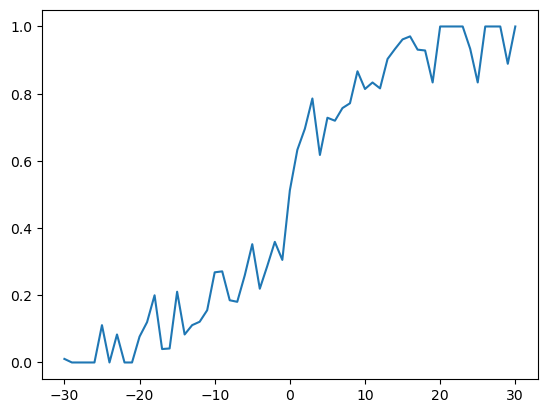

In [139]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [140]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.4520988481844852
logloss of cvsplit 1: 0.44476767138072376
logloss of cvsplit 2: 0.4521093731491979


In [141]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.45213500667620854
adjusted logloss of cvsplit 1: 0.4445226863548373
adjusted logloss of cvsplit 2: 0.452093914253244


In [142]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.124112122557455
adjusted logloss of cvsplit 1: 1.1175610514847363
adjusted logloss of cvsplit 2: 1.123824843187457


In [143]:
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em,T1_3_Stars,T1_4_Stars,T1_5_Stars,T1_Total_Stars,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T2_adj_o,T2_adj_d,T2_luck,T2_rank,T2_adj_em,T2_3_Stars,T2_4_Stars,T2_5_Stars,T2_Total_Stars,T1_seed,T2_seed,Seed_diff
1753,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,8.393939,13.727273,8.575758,6.787879,14.060606,18.818182,50.151515,6.151515,20.303030,8.393939,8.848485,12.727273,3.878788,2.636364,14.151515,0.0,0.0,0.000,0.0,0.0000,1.0,0.0,0.0,3.0,25.612903,58.451613,9.838710,25.774194,9.709677,14.870968,11.677419,7.387097,16.516129,25.322581,56.612903,8.322581,23.161290,9.935484,13.580645,14.322581,6.258065,2.806452,1.516129,0.0,0.0,0.000,0.0,0.0000,0.0,0.0,0.0,0.0,1,16,-15
2123,2023,137,1345,58,1192,63,25.441176,55.382353,6.882353,21.088235,11.029412,15.500000,10.411765,4.794118,13.705882,24.058824,57.705882,6.411765,20.411765,6.323529,12.382353,9.088235,6.000000,2.941176,10.352941,117.6,94.4,0.021,8.0,23.2100,1.0,0.0,0.0,3.0,27.781250,61.593750,7.843750,22.781250,9.875000,14.312500,11.156250,7.437500,19.125000,26.656250,55.062500,8.156250,22.093750,7.687500,15.031250,14.187500,5.593750,3.875000,0.312500,106.7,115.1,0.011,265.0,-8.4100,0.0,0.0,0.0,0.0,1,16,-15
2124,2023,137,1345,58,1192,63,25.441176,55.382353,6.882353,21.088235,11.029412,15.500000,10.411765,4.794118,13.705882,24.058824,57.705882,6.411765,20.411765,6.323529,12.382353,9.088235,6.000000,2.941176,10.352941,117.6,94.4,0.021,8.0,23.2100,1.0,0.0,0.0,3.0,27.781250,61.593750,7.843750,22.781250,9.875000,14.312500,11.156250,7.437500,19.125000,26.656250,55.062500,8.156250,22.093750,7.687500,15.031250,14.187500,5.593750,3.875000,0.312500,106.7,115.1,0.011,265.0,-8.4100,0.0,0.0,0.0,0.0,1,16,-15
2125,2023,137,1345,58,1192,63,25.441176,55.382353,6.882353,21.088235,11.029412,15.500000,10.411765,4.794118,13.705882,24.058824,57.705882,6.411765,20.411765,6.323529,12.382353,9.088235,6.000000,2.941176,10.352941,117.6,94.4,0.021,8.0,23.2100,1.0,0.0,0.0,3.0,27.781250,61.593750,7.843750,22.781250,9.875000,14.312500,11.156250,7.437500,19.125000,26.656250,55.062500,8.156250,22.093750,7.687500,15.031250,14.187500,5.593750,3.875000,0.312500,106.7,115.1,0.011,265.0,-8.4100,0.0,0.0,0.0,0.0,1,16,-15
2126,2023,137,1345,58,1192,63,25.441176,55.382353,6.882353,21.088235,11.029412,15.500000,10.411765,4.794118,13.705882,24.058824,57.705882,6.411765,20.411765,6.323529,12.382353,9.088235,6.000000,2.941176,10.352941,117.6,94.4,0.021,8.0,23.2100,1.0,0.0,0.0,3.0,27.781250,61.593750,7.843750,22.781250,9.875000,14.312500,11.156250,7.437500,19.125000,26.656250,55.062500,8.156250,22.093750,7.687500,15.031250,14.187500,5.593750,3.875000,0.312500,106.7,115.1,0.011,265.0,-8.4100,0.0,0.0,0.0,0.0,1,16,-15
1537,2016,137,1277,81,1292,90,28.794118,59.529412,9.117647,21.029412,12.294118,20.558824,11.794118,4.411765,19.088235,21.794118,57.823529,5.676471,18.794118,9.352941,10.617647,9.558824,5.323529,3.235294,16.382353,121.3,94.8,-0.004,3.0,0.9450,0.0,2.0,2.0,18.0,25.903226,57.709677,8.000000,20.580645,10.258065,13.032258,11.935484,6.258065,20.451613,23.225806,54.322581,6.258065,18.354839,9.064516,11.451613,13.516129,5.838710,2.774194,4.096774,102.2,99.0,0.058,124.0,0.5926,0.0,0.0,0.0,0.0,2,15,-13
1538,2016,137,1277,81,1292,90,28.794118,59.529412,9.117647,21.029412,12.294118,20.558824,11.794118,4.411765,19.088235,21.794118,57.823529,5.676471,18.794118,9.352941,10.617647,9.

In [144]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.4169926785910698
adjusted logloss of cvsplit 1: 0.4111342257990846
adjusted logloss of cvsplit 2: 0.41684579210176115


In [145]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.4169926785910698
adjusted logloss of cvsplit 1: 0.4111342257990846
adjusted logloss of cvsplit 2: 0.41684579210176115


season
2015    0.382457
2016    0.298200
2017    0.484008
2018    0.532648
2019    0.464764
2021    0.560532
2022    0.402732
2023    0.342924
dtype: float64

# Do Submission formatting Below This 

In [146]:
sub = pd.read_csv("SampleSubmission2023.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106


In [147]:
seeds_T1.tail()

,Season,T1_TeamID,T1_seed
4093,2023,3405,12
4094,2023,3387,13
4095,2023,3241,14
4096,2023,3436,15
4097,2023,3151,16


In [148]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')


sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')


sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,TeamID_x,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em,T1_3_Stars,T1_4_Stars,T1_5_Stars,T1_Total_Stars,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,TeamID_y,T2_adj_o,T2_adj_d,T2_luck,T2_rank,T2_adj_em,T2_3_Stars,T2_4_Stars,T2_5_Stars,T2_Total_Stars,T1_seed,T2_seed,Seed_diff
0,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,0.0,0.0,0.0,0.0,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,0.0,0.0,0.0,0.0,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,0.0,0.0,0.0,0.0,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,0.0,0.0,0.0,0.0,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,0.0,0.0,0.0,0.0,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [149]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [150]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2


In [151]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
"""
sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0
"""
sub[['ID','Pred']].to_csv("submission.csv", index = None)

In [152]:
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,TeamID_x,T1_adj_o,T1_adj_d,T1_luck,T1_rank,T1_adj_em,T1_3_Stars,T1_4_Stars,T1_5_Stars,T1_Total_Stars,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,TeamID_y,T2_adj_o,T2_adj_d,T2_luck,T2_rank,T2_adj_em,T2_3_Stars,T2_4_Stars,T2_5_Stars,T2_Total_Stars,T1_seed,T2_seed,Seed_diff
0,2023_1101_1102,0.323671,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,0.0,0.0,0.0,0.0,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,2023_1101_1102,0.323671,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,0.0,0.0,0.0,0.0,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,2023_1101_1102,0.323671,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,0.0,0.0,0.0,0.0,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,2023_1101_1102,0.323671,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,0.0,0.0,0.0,0.0,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,2023_1101_1102,0.323671,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,1101,105.7,107.1,-0.05,193.0,-1.42,0.0,0.0,0.0,0.0,23.625,51.125,8.15625,22.90625,5.625,15.3125,10.90625,5.75,17.0,23.875,53.6875,5.1875,17.6875,7.9375,10.09375,10.6875,5.71875,3.09375,-0.125,1102,105.8,104.5,-0.057,147.0,1.27,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [153]:
round_slots = pd.read_csv('MNCAATourneySlots.csv')
round_slots = round_slots[round_slots['Season'] == 2023]
round_slots = round_slots[round_slots['Slot'].str.contains('R')] # Filter out First Four

seeds = pd.read_csv('2024_tourney_seeds.csv')
seeds_m = seeds[seeds['Tournament'] == 'M']
seeds_w = seeds[seeds['Tournament'] == 'W']

# Predictions of last year's 1st place solution by RustyB: https://www.kaggle.com/code/rustyb/paris-madness-2023/output
preds = pd.read_csv('submission.csv') 
preds['ID'] = preds['ID'].str.split('_')

In [154]:
from tqdm import tqdm
def prepare_data(seeds, preds):
    # Function preparing the data for the simulation
    seed_dict = seeds.set_index('Seed')['TeamID'].to_dict()
    inverted_seed_dict = {value: key for key, value in seed_dict.items()}
    probas_dict = {}
    
    for teams, proba in zip(preds['ID'], preds['Pred']):
        team1, team2 = teams[1], teams[2]

        probas_dict.setdefault(team1, {})[team2] = proba
        probas_dict.setdefault(team2, {})[team1] = 1 - proba

    return seed_dict, inverted_seed_dict, probas_dict


def simulate(round_slots, seeds, inverted_seeds, probas, random_values, sim=True):
    '''
    Simulates each round of the tournament.

    Parameters:
    - round_slots: DataFrame containing information on who is playing in each round.
    - seeds (dict): Dictionary mapping seed values to team IDs.
    - inverted_seeds (dict): Dictionary mapping team IDs to seed values.
    - probas (dict): Dictionary containing matchup probabilities.
    - random_values (array-like): Array with precomputed random-values.
    - sim (boolean): Simulates match if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - list: List with winning team IDs for each match.
    - list: List with corresponding slot names for each match.
    '''
    winners = []
    slots = []

    for slot, strong, weak, random_val in zip(round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed, random_values):
        team1, team2 = seeds[strong], seeds[weak]

        # Get the probability of team_1 winning
        proba = probas[str(team1)][str(team2)]
            
        if sim:
            # Randomly determine the winner based on the probability
            winner = team1 if random_val < proba else team2
        else:
            # Determine the winner based on the higher probability
            winner = [team1, team2][np.argmax([proba, 1-proba])]
            
        # Append the winner and corresponding slot to the lists
        winners.append(winner)
        slots.append(slot)

        seeds[slot] = winner

    # Convert winners to original seeds using the inverted_seeds dictionary
    return [inverted_seeds[w] for w in winners], slots


def run_simulation(brackets=1, seeds=None, preds=None, round_slots=None, sim=True):
    '''
    Runs a simulation of bracket tournaments.

    Parameters:
    - brackets (int): Number of brackets to simulate.
    - seeds (pd.DataFrame): DataFrame containing seed information.
    - preds (pd.DataFrame): DataFrame containing prediction information for each match-up.
    - round_slots (pd.DataFrame): DataFrame containing information about the tournament rounds.
    - sim (boolean): Simulates matches if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - pd.DataFrame: DataFrame with simulation results.
    '''
    # Get relevant data for the simulation
    seed_dict, inverted_seed_dict, probas_dict = prepare_data(seeds, preds)
    # Lists to store simulation results
    results = []
    bracket = []
    slots = []
    
    # Precompute random-values
    random_values = np.random.random(size=(brackets, len(round_slots)))

    # Iterate through the specified number of brackets
    for b in tqdm(range(1, brackets+1)):
        # Run single simulation
        r, s = simulate(round_slots, seed_dict, inverted_seed_dict, probas_dict, random_values[b-1], sim)
        
        # Update results
        results.extend(r)
        bracket.extend([b] * len(r))
        slots.extend(s)

    # Create final DataFrame
    result_df = pd.DataFrame({'Bracket': bracket, 'Slot': slots, 'Team': results})

    return result_df

n_brackets = 10000
result_m=run_simulation(brackets=n_brackets, seeds=seeds_m, preds=preds, round_slots=round_slots, sim=True)
result_m['Tournament'] = 'M'
result_w=run_simulation(brackets=n_brackets, seeds=seeds_w, preds=preds, round_slots=round_slots, sim=True)
result_w['Tournament'] = 'W'
submission = pd.concat([result_m, result_w])
submission.reset_index(inplace=True, drop=True)
submission.index.names = ['RowId']

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 28624.92it/s]


In [155]:
# submission.to_csv('submission.csv')
submission = submission[['Tournament', 'Bracket', 'Slot', 'Team']]
submission

,Tournament,Bracket,Slot,Team
RowId,,,,
0,M,1,R1W1,W01
1,M,1,R1W2,W15
2,M,1,R1W3,W03
3,M,1,R1W4,W13
4,M,1,R1W5,W05
...,...,...,...,...
1259995,W,10000,R4Y1,Y03
1259996,W,10000,R4Z1,Z04
1259997,W,10000,R5WX,W01


In [156]:
# Filter the DataFrame for men's and women's tournaments separately
submission_men = submission[submission['Tournament'] == 'M']
submission_women = submission[submission['Tournament'] == 'W']

# Get value counts of winning teams separately for men's and women's tournaments
winning_teams_counts_men = submission_men['Team'].value_counts()
winning_teams_counts_women = submission_women['Team'].value_counts()

# Display value counts for men's and women's tournaments
print("Winning Teams Counts for Men's Tournament:")
print(winning_teams_counts_men)
print("\nWinning Teams Counts for Women's Tournament:")
print(winning_teams_counts_women)

Winning Teams Counts for Men's Tournament:
Team
W01    47595
Y03    22225
X05    21763
Y07    20905
Y02    20838
       ...  
X16     1689
X12     1371
W16      372
Y15      355
Y10      328
Name: count, Length: 64, dtype: int64

Winning Teams Counts for Women's Tournament:
Team
W01    40852
Z04    31956
X11    27524
Z06    25626
X02    25473
       ...  
Z05      493
Z16      449
Y04      422
X16      350
Z08      316
Name: count, Length: 64, dtype: int64


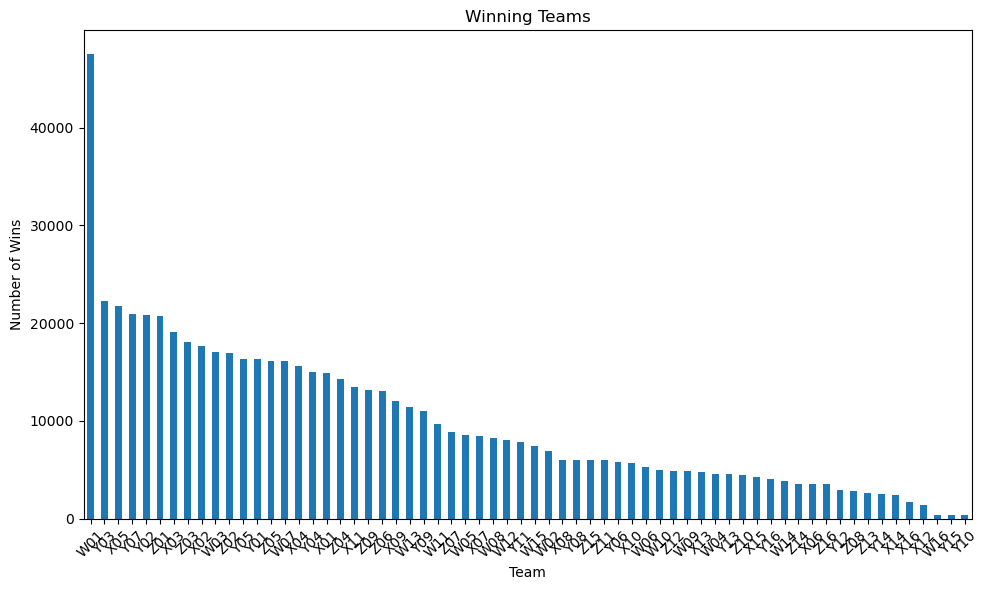

In [157]:
#winning_teams_counts = df_submission['Team'].value_counts()

plt.figure(figsize=(10, 6))
winning_teams_counts_men.plot(kind='bar')
plt.title('Winning Teams')
plt.xlabel('Team')
plt.ylabel('Number of Wins')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [158]:
#!pip install --upgrade setuptools
#!pip install --upgrade binarytree
#!pip install bracketeer

#from bracketeer import build_bracket

In [159]:
seed_and_IDs = pd.read_csv('2024_tourney_seeds.csv')
seed_and_IDs

,Tournament,Seed,TeamID
0,M,W01,1163
1,M,W02,1235
2,M,W03,1228
3,M,W04,1120
4,M,W05,1361
...,...,...,...
123,W,Z12,3162
124,W,Z13,3267
125,W,Z14,3238
126,W,Z15,3263


In [160]:
TeamName_and_ID = pd.read_csv('MTeams.csv')
TeamName_and_ID

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2024
1,1102,Air Force,1985,2024
2,1103,Akron,1985,2024
3,1104,Alabama,1985,2024
4,1105,Alabama A&M,2000,2024
...,...,...,...,...
373,1474,Queens NC,2023,2024
374,1475,Southern Indiana,2023,2024
375,1476,Stonehill,2023,2024
376,1477,TX A&M Commerce,2023,2024


In [161]:

seeds_to_names = pd.merge(TeamName_and_ID, seed_and_IDs, on='TeamID', how='inner')

# Display the merged DataFrame
seeds_to_names = seeds_to_names[['TeamName', 'Seed']]

seeds_to_names


,TeamName,Seed
0,Akron,Y14
1,Alabama,X04
2,Arizona,X02
3,Auburn,W04
4,Baylor,X03
...,...,...
59,Vermont,Z13
60,WKU,Z15
61,Washington St,W07
62,Wisconsin,Z05


In [162]:
import pandas as pd

# Assuming you have the submission_men DataFrame loaded already

# Get the counts of winning teams
winning_teams_counts_men = submission_men['Team'].value_counts()

# Convert the Series to a DataFrame
winning_teams_counts_men_df = winning_teams_counts_men.to_frame().reset_index()

# Rename the columns
winning_teams_counts_men_df.columns = ['Seed', 'Number of Wins']

# Display the DataFrame
winning_teams_counts_men_df


,Seed,Number of Wins
0,W01,47595
1,Y03,22225
2,X05,21763
3,Y07,20905
4,Y02,20838
...,...,...
59,X16,1689
60,X12,1371
61,W16,372
62,Y15,355


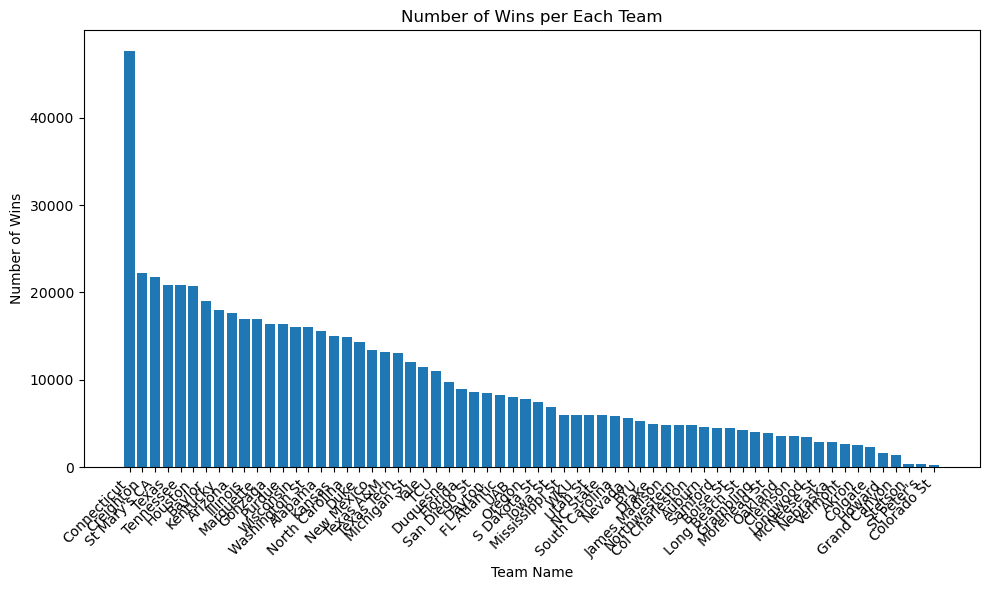

In [163]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have seeds_to_names and winning_teams_counts_men_df DataFrames loaded already

# Merge the DataFrames on the 'Seed' column
merged_data = pd.merge(seeds_to_names, winning_teams_counts_men_df, on='Seed', how='inner')

# Sort the merged DataFrame by 'Number of Wins' in descending order
merged_data_sorted = merged_data.sort_values(by='Number of Wins', ascending=False)

# Plot the number of wins associated with each team name
plt.figure(figsize=(10, 6))
plt.bar(merged_data_sorted['TeamName'], merged_data_sorted['Number of Wins'])
plt.xlabel('Team Name')
plt.ylabel('Number of Wins')
plt.title('Number of Wins per Each Team')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
